# SENG 474
# Assignment 3 - Problem 2
# Nolan Kurylo
# V00893175
To execute notebook, ensure ALL cells are run from top to bottom (since imports/df creation are only called once)

References:

1) https://www.askpython.com/python/examples/k-means-clustering-from-scratch

2) https://mmuratarat.github.io/2019-07-23/kmeans_from_scratch

3) https://medium.com/machine-learning-algorithms-from-scratch/k-means-clustering-from-scratch-in-python-1675d38eee42

4) https://www.scikit-yb.org/en/latest/api/cluster/elbow.html#:~:text=If%20the%20line%20chart%20looks,fits%20best%20at%20that%20point.

5) https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn


The following formulas were used for both initialization techniques in Problem 2.1

Euclidian Distance between two points:
$
d(x,x') =  \sqrt{ \sum_{i=1}^d (x_i - x_i')^2 } 
$

Squared Distance between two points (for k-means++ initialization):

$
d(x,x')^2 = \sum_{i=1}^d (x_i - x_i')^2
$
Closest centroid to point:

$
closest \ centroid = argmin_{centroid_i \ \epsilon \ centroids} [d(x,x')]
$

Mean of a cluster (centroid) - computed using numpy.mean():

$
centroid_j =  \frac{ \sum_{x_i \ \epsilon \ centroid_j}  x_i }{|centroid_j|} 
$

In [1]:
# 2.1 Lloyd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 

np.random.seed(1337)


def initializationTechnique(X, K, technique): 
    """ Creayes a list of K indices of X of where to initialize the centroids based on the technique
    :param X: dataset
    :param K: number of centroids to create
    :param technique: k-means++ or random
    :return: indices of X of the locations of the K chosen centroids
    """
    
    if(technique == 'k-means++'):
        #Create first centroid
        random_index = np.random.choice(X.shape[0], size=1, replace=False)[0] # choose a random index for first centroid

        centroids = np.zeros((K, X.shape[1]))
        centroids[0] = X[random_index] # list to store centeroid points of X
        centroid_idxs = [random_index] # list to store centeroid indices of X
        
        k = 1 # created k=0 above
        while k < K: # create the remainding K-1 centroids
            distances = [] # sum of squared distance for each point
            for i in range(X.shape[0]): # for each point in X, find its sum of squared distance from the centroids
                point = X[i,:]
                point_distance = findSquaredDistance(point, centroids)
                distances.append(point_distance) # append the point's sum of squared distance to the rest

            total_distance = np.sum(distances)
            cummulative_probability = np.cumsum(distances / total_distance) # cummulative probability of the sum of squared distance for each point in X
            random_probability = random.random() # generate a random probability between 0 and 1 to find the index in X with a greater probability
            centroid_idx = np.where(cummulative_probability > random_probability)[0][0] # select first index in X with a greater probability

            # Add in the new centroid
            centroid_idxs.append(centroid_idx) 
            centroids[k] = X[centroid_idx]
            k += 1

        return centroid_idxs
        

    else: # technique == 'random'
        return np.random.choice(X.shape[0], size=K, replace=False) # choose K random indices for first centroid

def findSquaredDistance(point, centroids): 
    """ Finds the sum of squared distances from the input point
    :param point: current data point
    :param centroids: array of the K centroids
    :return: vector containing squared distance between point and each centroid 
    """
    return np.sum(np.square(point-centroids))


def findEuclidianDistances(centroids, X, K): 
    """ Finds the euclidian distance from each point in X to each cluster's mean (centroid)
    :param centroids: array of the K centroids
    :param X: dataset
    :param K: number of centroids 
    :return: vector containing euclidean distance between each point in X and each centroid 
    """
    
    euclidian_distances = np.zeros((X.shape[0], K))

    for centroid in range(K): # for each of the K centroids
        euclidian_distances[:, centroid] = np.sqrt(np.sum(np.square(X - centroids[centroid]), axis=1)) # find euclidian distance between each point and centroids ### add latex
    
    return euclidian_distances

def findClosestCentroid(euclidian_distances): 
    """ Finds the nearest centroid index for each point in X 
    :param euclidian_distances: euclidean distance between each centroid and each point in X
    :return: vector containing the closest centroid for each point in X
    """
    
    closest_centroids = np.array([], dtype=int)
    for point_distances in euclidian_distances: # for each point's corresponding distances to each of the K centroids
        closest_K = np.argmin(point_distances) # find the index (nearest centroid K) that has the smallest distance to point X
        closest_centroids = np.append(closest_centroids, closest_K)
    return closest_centroids

def updateCentroids(X, clustered_points, K): 
    """ Finds the d-dimensional locations of each of the K centroids
    :param X: dataset
    :param clustered_points: vector mapping each point to a centroid (cluster)
    :param K: number of centroids
    :return: vector mapping each point to their newest closest centroid (cluster)
    """
    
    updated_centroids = np.zeros((K, X.shape[1]))
    
    for centroid in range(K): # for each of the K centroids
        centroid_idxs = clustered_points == centroid # find the indices of X that belong to the current centroid (cluster)
        updated_centroids[centroid] = X[centroid_idxs].mean(axis=0) # caclulate the means of all points in the current closest centroid (cluster)
    
    return updated_centroids

 
def LloydKMeans(X, max_iterations, K, init_technique): 
    """ Finds closest_centroid corresponding to each point in X and the location of the centroids
    :param X: dataset
    :param max_iterations: hyperparemeter
    :param K: number of cluster to create
    :param init_technique: how to initialize each centroid (k-means++ or random)
    :return: points in each cluster and the centroids of each cluster
    """
    
    # Find the indices of the initial centroids
    centroid_idxs = initializationTechnique(X, K, init_technique)

    # Init the following so they can be looped over multiple iterations:
    centroids = X[centroid_idxs, :] 
    euclidian_distances = findEuclidianDistances(centroids, X, K) # find the distance between each centroid for each point
    clustered_points = findClosestCentroid(euclidian_distances) # finds the nearest centroid index for each point in X

    iteration = 0
    while(iteration < max_iterations):# run what was done above for a variable number of iterations

        centroids = updateCentroids(X,clustered_points, K) # update where each centroid is located
        euclidian_distances = findEuclidianDistances(centroids, X, K) # find the distance between each point in X and the new centroids
        clustered_points = findClosestCentroid(euclidian_distances) # finds the nearest centroid index for each point in X

        iteration += 1
         
    return clustered_points, centroids 
 


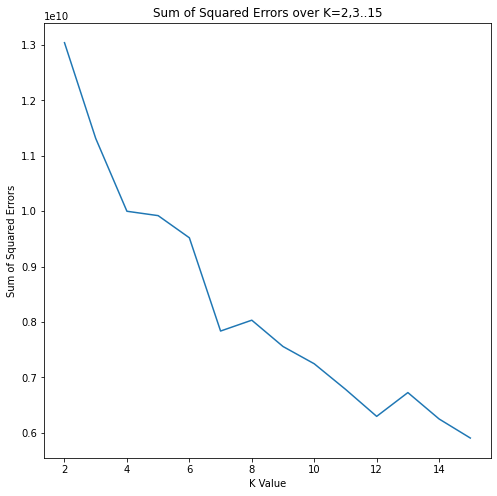

In [2]:
# 2.1 Lloyd - Random Initialization
df = pd.read_csv('fashion_mnist_pca.csv') # create dataframe of csv (PCA data) from Problem 1.2
y = np.array(df['label'])
X = np.array(df.drop('label', axis=1))

num_iterations = 1 # the more the longer it takes to run
K_values = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# calculate the sum of sqaured errors for each value of K
sum_squared_errors = []
for K in K_values: # add the sum of squared errors for each K to be plotted afterwards
    clustered_points, cluster_locations = LloydKMeans(X, num_iterations, K, 'random') # perform K-Means clustering on input K and get the cluster points + centroids
    cluster_sum_squared_errors = 0
    for cluster in range(K): # for each cluster, add up the sum of squared errors for each point in the cluster to the centroid
        class_points = clustered_points == cluster
        cluster_sum_squared_errors += np.sum(np.square(X[class_points] - cluster_locations[cluster,:]))
    sum_squared_errors.append(cluster_sum_squared_errors)
plt.figure(figsize=(8,8))
plt.title('Sum of Squared Errors over K=2,3..15')
plt.xlabel('K Value')
plt.ylabel('Sum of Squared Errors')
plt.plot(K_values,sum_squared_errors)
plt.show()

2.1 Lloyd - Random Initialization

After initializing the k-means/Lloyds algorithm to K distinct points in the dataset, the algorithm was ran for values of K from 2 to 15. As seen in the Sum of Squared Errors plot, the "elbow" is somewhat hard to see. The "elbow" is the point in the graph at which the optimal value of K resides. From the outputted graph, the best value of K can be seen to be at K = 7, where the graph goes from vetical to more horizontal. This means that there should be 7 clusters for the final clustering. We know this value is incorrect as the actual number of classes is 10. Random initialization has shown to choose an optimal value of K which is 3 off from the actual number of classes, perhaps k-means++ initialization will do better below...

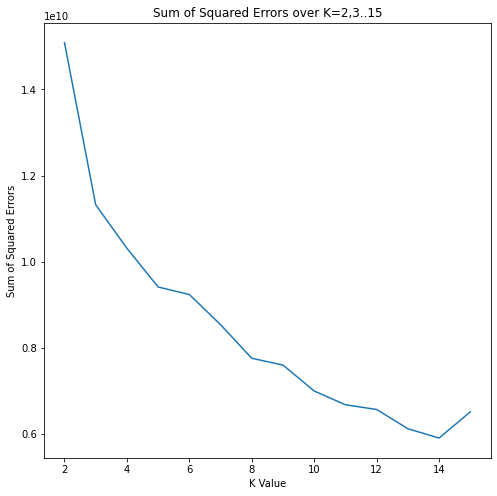

In [3]:
# 2.1 Lloyd - k-means++ Initialization

num_iterations = 1 # the more the longer it takes to run
K_values = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# calculate the sum of sqaured errors for each value of K
sum_squared_errors = []
for K in K_values: # add the sum of squared errors for each K to be plotted afterwards
    clustered_points, cluster_locations = LloydKMeans(X, num_iterations, K, 'k-means++') # perform K-Means clustering on input K and get the cluster points + centroids
    cluster_sum_squared_errors = 0
    for cluster in range(K): # for each cluster, add up the sum of squared errors for each point in the cluster to the centroid
        class_points = clustered_points == cluster
        cluster_sum_squared_errors += np.sum(np.square(X[class_points] - cluster_locations[cluster,:]))
    sum_squared_errors.append(cluster_sum_squared_errors)
plt.figure(figsize=(8,8))
plt.title('Sum of Squared Errors over K=2,3..15')
plt.xlabel('K Value')
plt.ylabel('Sum of Squared Errors')
plt.plot(K_values,sum_squared_errors)
plt.show()

2.1 Lloyd - k-means++ Initialization

After initializing the k-means/Lloyds algorithm with k-means++, the first centroid was chosen randomly where the following centroids where determined based on the probability that the squared distance of a point is closest to the center. Each next centroid was chosen by taking the cummulative probability of squared distances and finding where it is larger than some random probability.From there, choosing the first correspponding point that is above the probability threshold.

The graph of Sum of Squared Errors for K ranging from 2 to 15 was ambigious like the graph generated from when K was initialized randomly. However, the "elbow" can be seen to be at K = 8, where the graph goes from a vertical to a more horizontal shape. This goes to show that the k-means++ initialization more closely approximated the number of clusters to generate. While still off from the actual number of classes (10), the k-means/Lloyds algorithm can more accurately cluster the data than it did with random initialization.

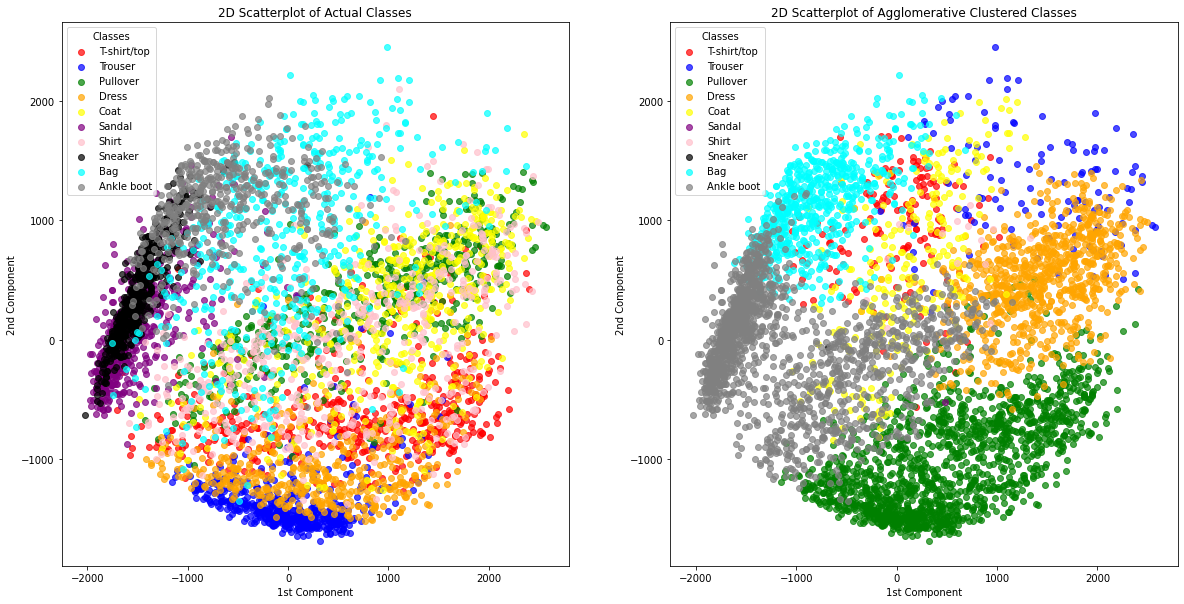

Number of points classified as T-shirt/top: 166 / 5000
Number of points classified as Trouser: 126 / 5000
Number of points classified as Pullover: 1480 / 5000
Number of points classified as Dress: 804 / 5000
Number of points classified as Coat: 256 / 5000
Number of points classified as Sandal: 1 / 5000
Number of points classified as Shirt: 15 / 5000
Number of points classified as Sneaker: 1 / 5000
Number of points classified as Bag: 621 / 5000
Number of points classified as Ankle Boot: 1530 / 5000
Plotting Dendogram ... this takes ~2-3 minutes


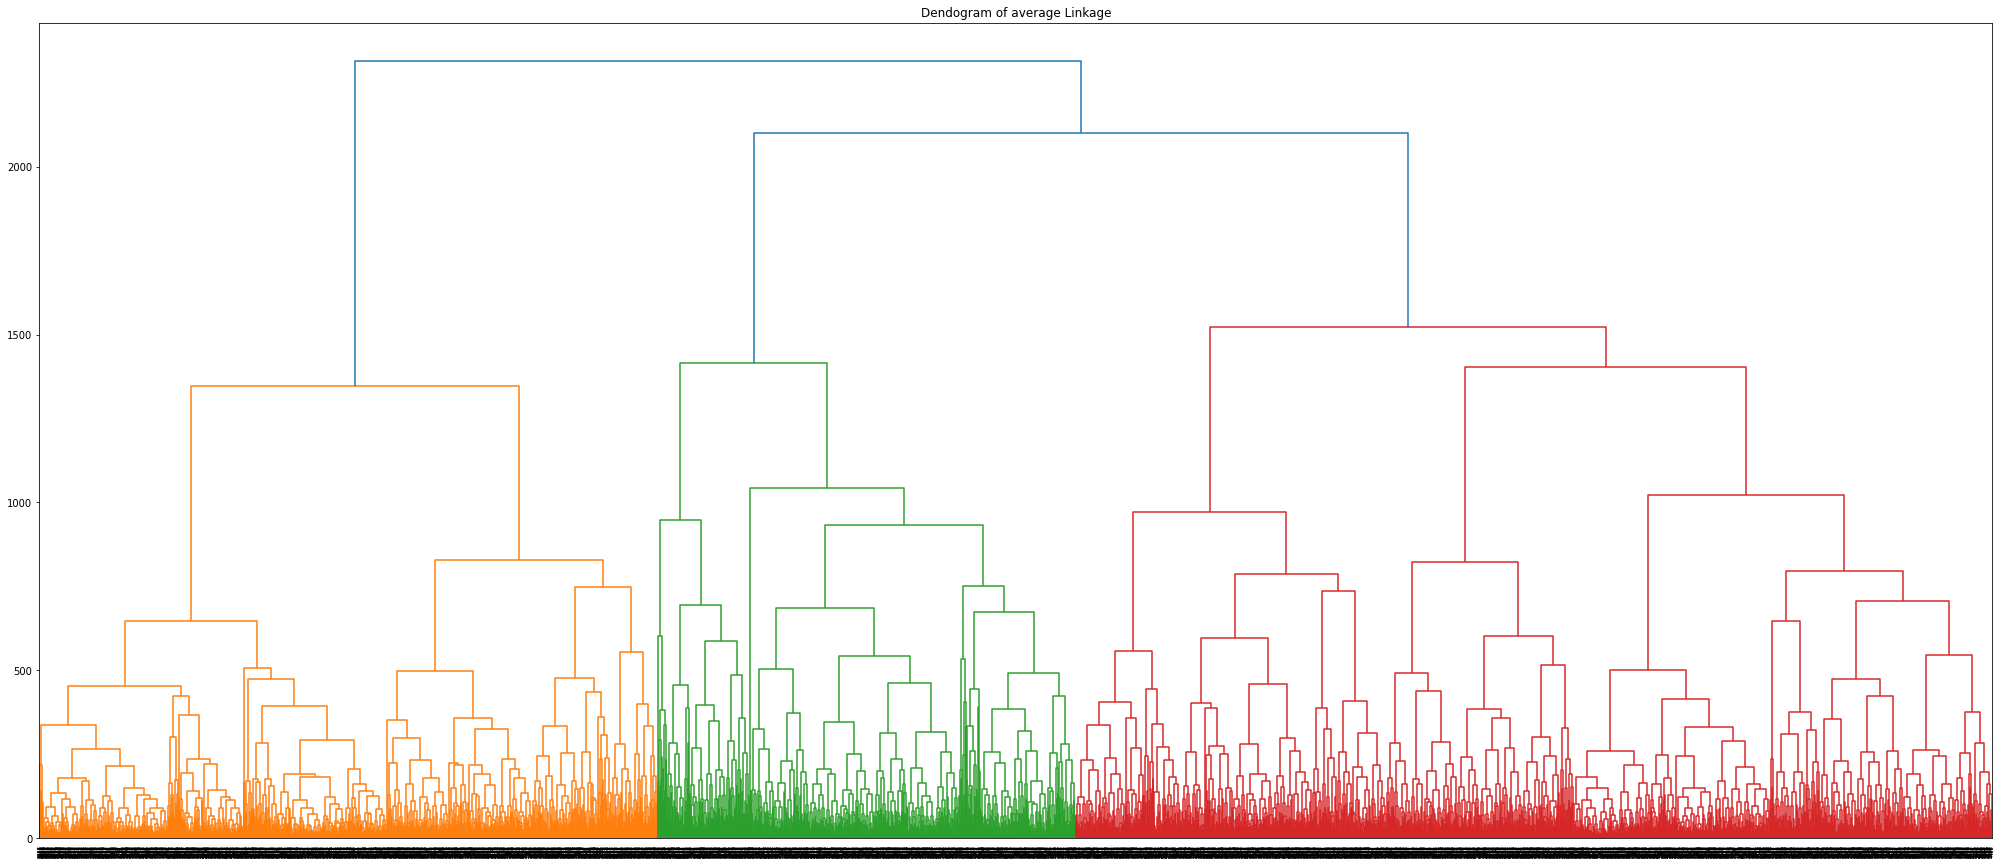

In [4]:
# 2.2 Hierarchical
# Average Linkage
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch


df = pd.read_csv('fashion_mnist_pca.csv') # create dataframe of csv (PCA data) from Problem 1.2
y = df['label'] 
X = df.drop('label', axis=1) 


np_X = np.array(X) # same datasets just need to convert to numpy arrays for plotting scatterplots
np_y = np.array(y)

linkage = 'average'

model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage=linkage) # run the hierarchical agglomerative clustering algorithm on the dataset

model.fit_predict(X)
predicted_classes = model.labels_ # obtain the predicted classes

# plot scatterplots and compare the results
plt.figure(figsize=(20,10))
colours = {0: 'red', 1:'blue', 2: 'green', 3:'orange', 4:'yellow', 5:'purple', 6:'pink', 7:'black', 8:'cyan', 9:'grey'} # classes and assigned corresponding colour

# plot the actual classes
plt.subplot(1,2,1)
for class_colour in colours:
    class_rows = np_y == class_colour
    plt.scatter(x=np_X[class_rows,0], y=np_X[class_rows,1], c=colours[class_colour], label=class_colour, alpha=0.7 )

plt.title("2D Scatterplot of Actual Classes")
plt.xlabel("1st Component")
plt.ylabel("2nd Component")
plt.legend(title = "Classes", labels= ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

# plot the agglomerative clustered classes
plt.subplot(1,2,2)
for class_colour in colours:
    class_rows = predicted_classes == class_colour
    plt.scatter(x=np_X[class_rows,0], y=np_X[class_rows,1], c=colours[class_colour], label=class_colour, alpha=0.7)

plt.title("2D Scatterplot of Agglomerative Clustered Classes")
plt.xlabel("1st Component")
plt.ylabel("2nd Component")
plt.legend(title = "Classes", labels= ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.show()

num_class_0_points = np.where(predicted_classes == 0)
num_class_1_points = np.where(predicted_classes == 1)
num_class_2_points = np.where(predicted_classes == 2)
num_class_3_points = np.where(predicted_classes == 3)
num_class_4_points = np.where(predicted_classes == 4)
num_class_5_points = np.where(predicted_classes == 5)
num_class_6_points = np.where(predicted_classes == 6)
num_class_7_points = np.where(predicted_classes == 7)
num_class_8_points = np.where(predicted_classes == 8)
num_class_9_points = np.where(predicted_classes == 9)
print("Number of points classified as T-shirt/top: " + str(num_class_0_points[0].shape[0] )+" / 5000")
print("Number of points classified as Trouser: " + str(num_class_1_points[0].shape[0] )+" / 5000")
print("Number of points classified as Pullover: " + str(num_class_2_points[0].shape[0] )+" / 5000")
print("Number of points classified as Dress: " + str(num_class_3_points[0].shape[0] )+" / 5000")
print("Number of points classified as Coat: " + str(num_class_4_points[0].shape[0] )+" / 5000")
print("Number of points classified as Sandal: " + str(num_class_5_points[0].shape[0] )+" / 5000")
print("Number of points classified as Shirt: " + str(num_class_6_points[0].shape[0] )+" / 5000")
print("Number of points classified as Sneaker: " + str(num_class_7_points[0].shape[0] )+" / 5000")
print("Number of points classified as Bag: " + str(num_class_8_points[0].shape[0] )+" / 5000")
print("Number of points classified as Ankle Boot: " + str(num_class_9_points[0].shape[0] )+" / 5000")

print("Plotting Dendogram ... this takes ~2-3 minutes")
plt.figure(figsize =(35, 15))
plt.title("Dendogram of " + linkage +" Linkage")
dendo_data = X.iloc[:, 0:2].values
dendrogram = sch.dendrogram(sch.linkage(dendo_data, method=linkage)) # generate dendogram based on average linkage
plt.show()





 2.2 Hierarchical - Average Linkage
 
 As seen by the scatterplots of the actual classes and the agglomerative clustered classes, most of the agglomerative clustered classes do not correspond to their correct labels. Based on the scatterplot of the actual classes, the excessive overlapping over actual classes implies that it will be a very hard problem for any human eye or algorithm to distinguish which point belongs to which class. The dendogram that was generated shows the hierarchical structure of the points in the dataset. To determine the correct number of classes based on the dendogram, a "cut" should be made throught the longest distance that seperates 2 horizontal lines. This can be picture by extending every horizontal line on the graph to the full width of the graph, then finding the largest vertical distance between neighbouring horizontal lines. For this dendogram the cut should be made around y = 1700. This implies that there should be 3 final classes. Again, based on the large amount of overlapping that occurs in the actual scatterplot, it is expected that the number of predicted classes will be off from 10. 

 

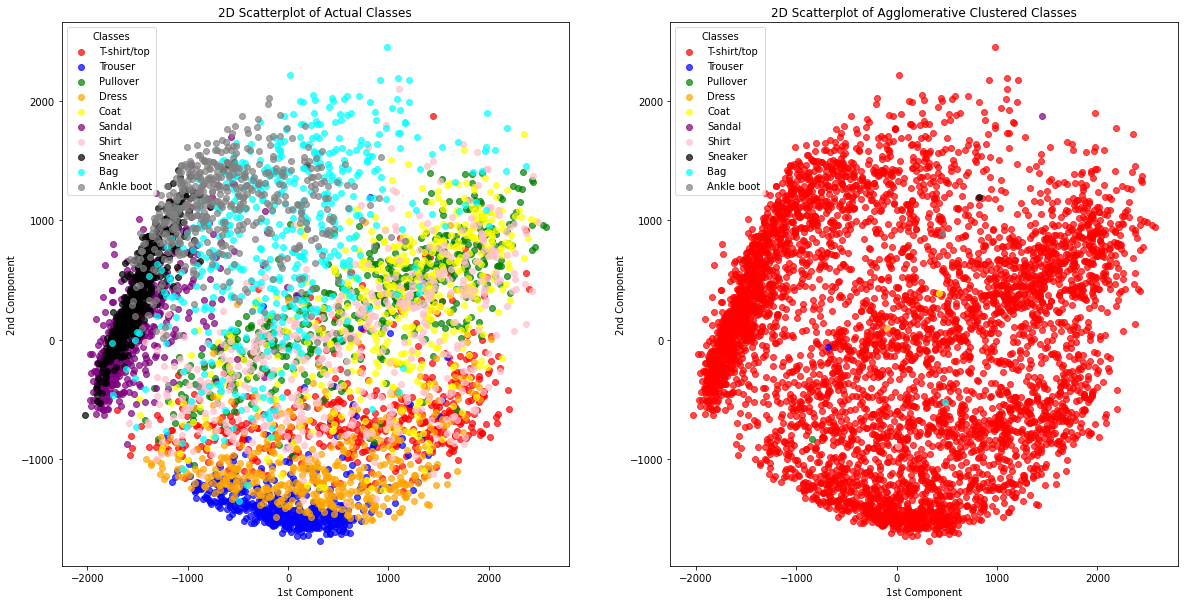

Number of points classified as T-shirt/top: 4991 / 5000
Number of points classified as Trouser: 1 / 5000
Number of points classified as Pullover: 1 / 5000
Number of points classified as Dress: 1 / 5000
Number of points classified as Coat: 1 / 5000
Number of points classified as Sandal: 1 / 5000
Number of points classified as Shirt: 1 / 5000
Number of points classified as Sneaker: 1 / 5000
Number of points classified as Bag: 1 / 5000
Number of points classified as Ankle Boot: 1 / 5000
Plotting Dendogram ... this takes ~2-3 minutes


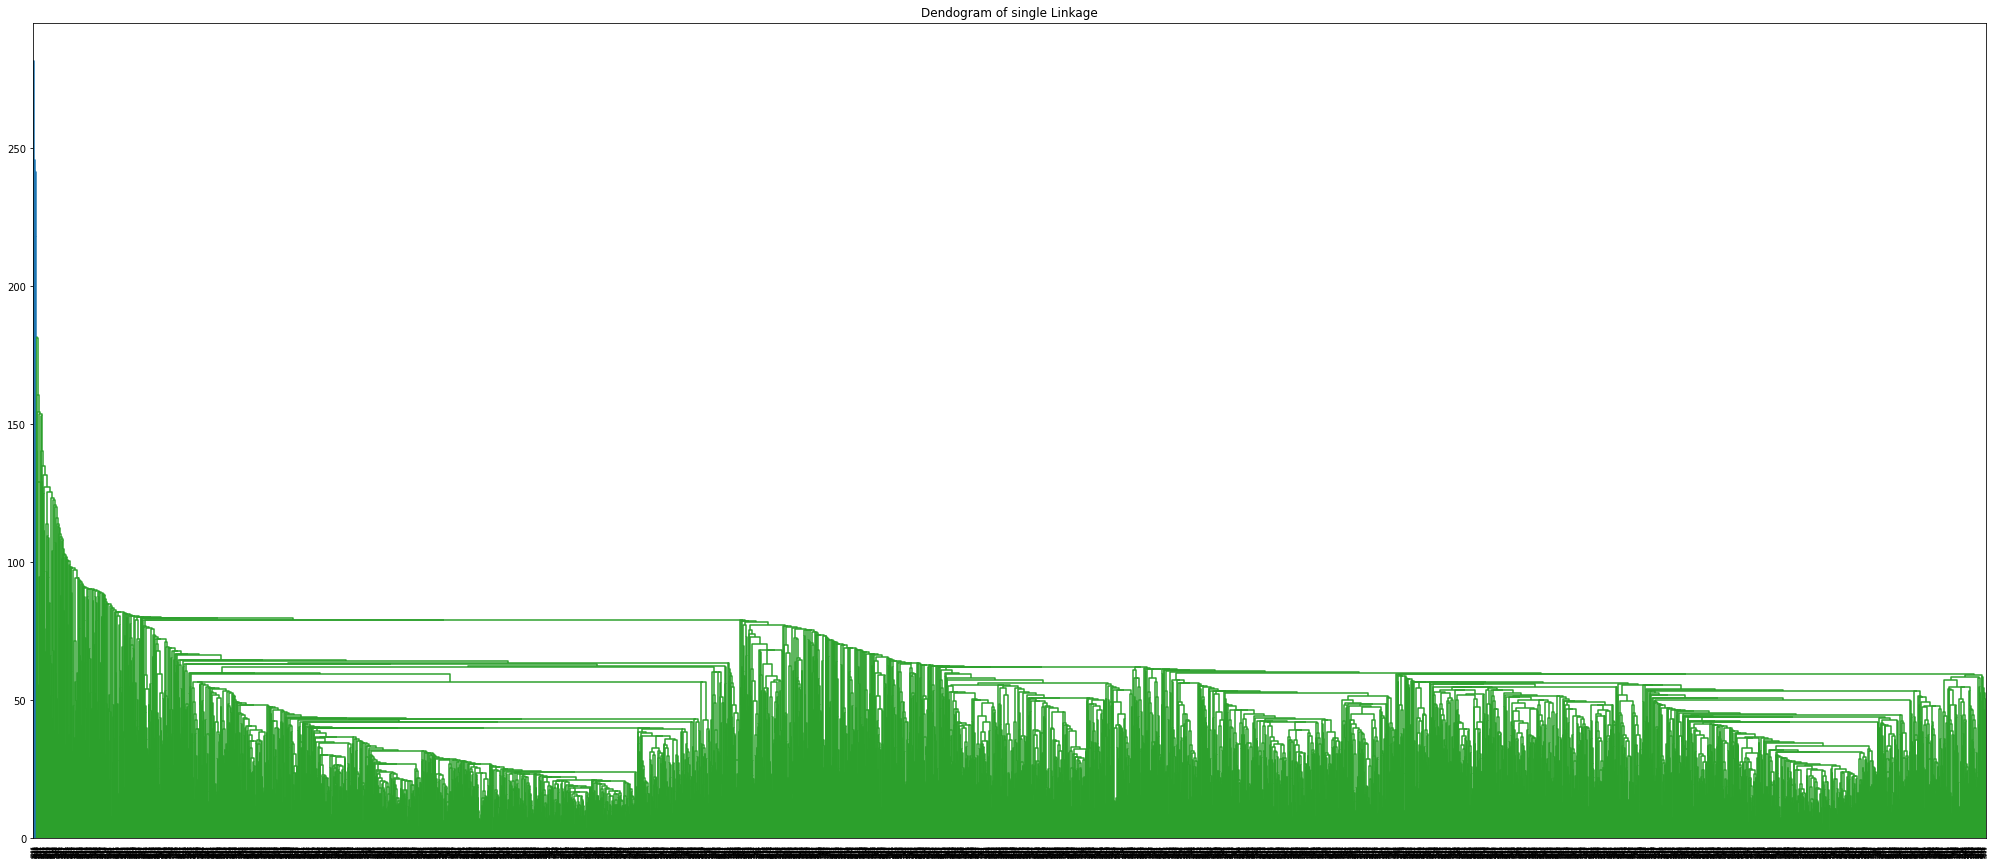

In [5]:
# 2.2 Hierarchical
# Single Linkage
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

y = df['label']
X = df.drop('label', axis=1)

np_X = np.array(X) # same datasets just need to convert to numpy arrays for plotting scatterplots
np_y = np.array(y)

linkage = 'single'

model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage=linkage) # run the hierarchical agglomerative clustering algorithm on the dataset

model.fit_predict(X)
predicted_classes = model.labels_ # obtain the predicted classes

# plot scatterplots and compare the results
plt.figure(figsize=(20,10))
colours = {0: 'red', 1:'blue', 2: 'green', 3:'orange', 4:'yellow', 5:'purple', 6:'pink', 7:'black', 8:'cyan', 9:'grey'} # classes and assigned corresponding colour

# plot the actual classes
plt.subplot(1,2,1)
for class_colour in colours:
    class_rows = np_y == class_colour
    plt.scatter(x=np_X[class_rows,0], y=np_X[class_rows,1], c=colours[class_colour], label=class_colour, alpha=0.7 )

plt.title("2D Scatterplot of Actual Classes")
plt.xlabel("1st Component")
plt.ylabel("2nd Component")
plt.legend(title = "Classes", labels= ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

# plot the agglomerative clustered classes
plt.subplot(1,2,2)
for class_colour in colours:
    class_rows = predicted_classes == class_colour
    plt.scatter(x=np_X[class_rows,0], y=np_X[class_rows,1], c=colours[class_colour], label=class_colour, alpha=0.7)

plt.title("2D Scatterplot of Agglomerative Clustered Classes")
plt.xlabel("1st Component")
plt.ylabel("2nd Component")
plt.legend(title = "Classes", labels= ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.show()


num_class_0_points = np.where(predicted_classes == 0)
num_class_1_points = np.where(predicted_classes == 1)
num_class_2_points = np.where(predicted_classes == 2)
num_class_3_points = np.where(predicted_classes == 3)
num_class_4_points = np.where(predicted_classes == 4)
num_class_5_points = np.where(predicted_classes == 5)
num_class_6_points = np.where(predicted_classes == 6)
num_class_7_points = np.where(predicted_classes == 7)
num_class_8_points = np.where(predicted_classes == 8)
num_class_9_points = np.where(predicted_classes == 9)
print("Number of points classified as T-shirt/top: " + str(num_class_0_points[0].shape[0] )+" / 5000")
print("Number of points classified as Trouser: " + str(num_class_1_points[0].shape[0] )+" / 5000")
print("Number of points classified as Pullover: " + str(num_class_2_points[0].shape[0] )+" / 5000")
print("Number of points classified as Dress: " + str(num_class_3_points[0].shape[0] )+" / 5000")
print("Number of points classified as Coat: " + str(num_class_4_points[0].shape[0] )+" / 5000")
print("Number of points classified as Sandal: " + str(num_class_5_points[0].shape[0] )+" / 5000")
print("Number of points classified as Shirt: " + str(num_class_6_points[0].shape[0] )+" / 5000")
print("Number of points classified as Sneaker: " + str(num_class_7_points[0].shape[0] )+" / 5000")
print("Number of points classified as Bag: " + str(num_class_8_points[0].shape[0] )+" / 5000")
print("Number of points classified as Ankle Boot: " + str(num_class_9_points[0].shape[0] )+" / 5000")

print("Plotting Dendogram ... this takes ~2-3 minutes")
plt.figure(figsize =(35, 15))
plt.title("Dendogram of " + linkage +" Linkage")
dendo_data = X.iloc[:, 0:2].values
dendrogram = sch.dendrogram(sch.linkage(dendo_data, method=linkage)) # generate dendogram based on average linkage
plt.show()




2.2 Hierarchical - Single Linkage


 As seen by the scatterplots of the actual classes and the agglomerative clustered classes, almost all of the agglomerative clustered classes do not correspond to their correct labels. The single linkage method ends up clustering almost the entire dataset as a "T-shirt/top". While the output shows that each class contains at least one point, the computation of single linkage has resulted in a problem. From the results, it is obvious that agglomerative clustering based on single linkage is not the proper way to cluster the data as it has failed. If a cut were to be made here, it would somewhat relate to the scatterplot having 4991 points in 1 class, which is obviously incorrect. Really, no cut should be made at all, single linkage has given a poor result. Average linkage should be used instead, or perhaps ward linkage could be tested out.